In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

In [ ]:
IMAGE_LIB = '/content/drive/MyDrive/AI/Keras/lung_ct/2d_images/*.tif'
MASK_LIB = '/content/drive/MyDrive/AI/Keras/lung_ct/2d_masks/*.tif'
IMG_SIZE = 224
SEED = 11

In [ ]:
img_paths = sorted(glob(IMAGE_LIB)) 
mask_paths = sorted(glob(MASK_LIB)) 

x_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))
y_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))

for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    x_data[i] = img

for i, path in tqdm(enumerate(mask_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED) / 255.
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    y_data[i] = img

0it [00:00, ?it/s]

0it [00:00, ?it/s]

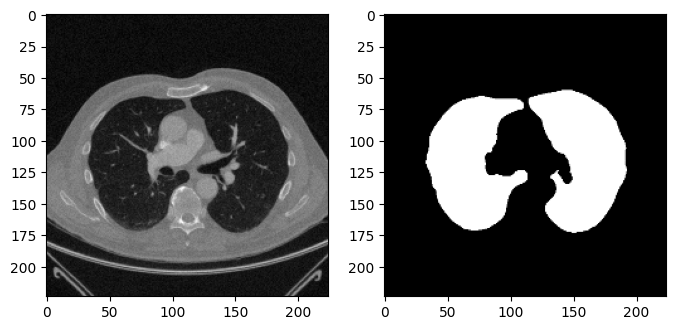

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [ ]:
x_data = np.expand_dims(x_data, axis=-1)
y_data = np.expand_dims(y_data, axis=-1)
#x_data = x_data / 255
#y_data = y_data / 255

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, random_state=11)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state=11)

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((192, 224, 224, 1),
 (27, 224, 224, 1),
 (48, 224, 224, 1),
 (192, 224, 224, 1),
 (27, 224, 224, 1),
 (48, 224, 224, 1))

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, concatenate, MaxPooling2D, BatchNormalization, Activation

In [ ]:
# Model:UNet++
inputs = Input((224, 224, 1))
#x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)


c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

outly = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)
model = Model(inputs=inputs, outputs=outly, name='U-net')

#model.summary()

In [ ]:
def dice_coef(y_test, y_pred):
  smooth = 1
  y_test_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_test_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_test_f * y_test_f) + K.sum(y_pred_f * y_pred_f) + smooth)

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, y_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

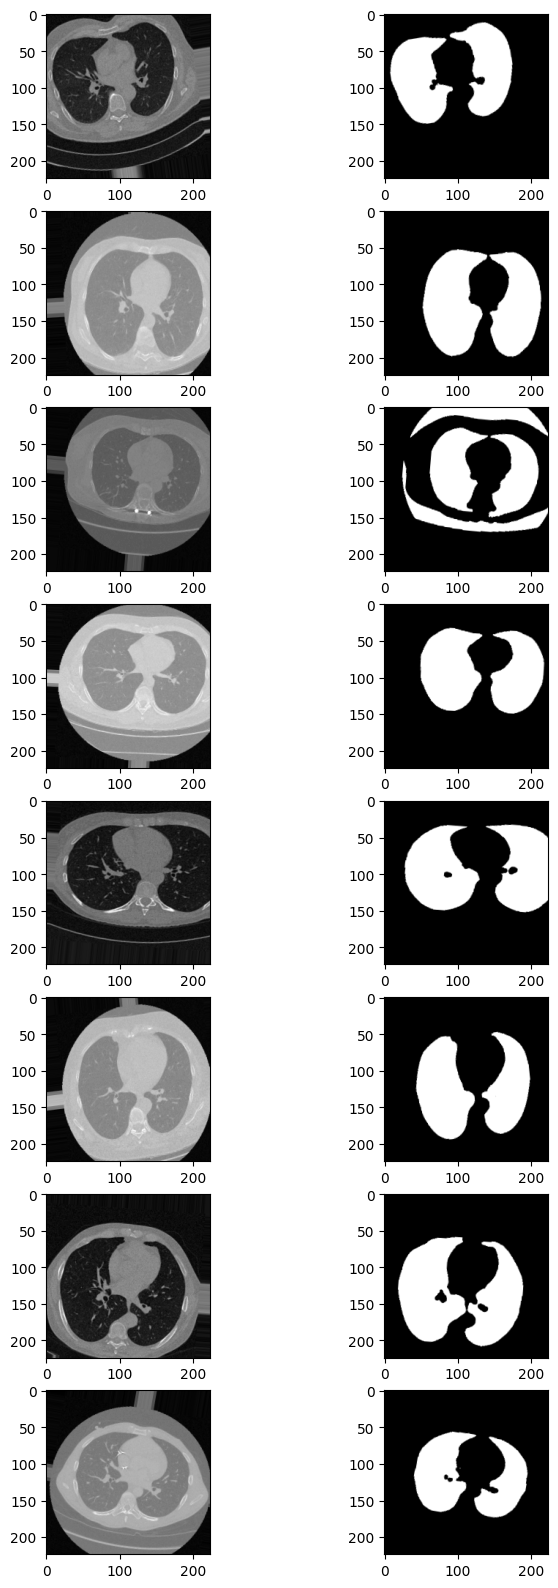

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap=plt.cm.gray)
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap=plt.cm.gray)
plt.show()

In [ ]:
model.compile(optimizer=Adam(0.00003), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size = 8),
                           steps_per_epoch = 100,
                           validation_data = (x_val, y_val),
                           epochs=100, verbose=1)

Epoch 1/100


<ipython-input-89-290d8037f0ce>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(my_generator(x_train, y_train, batch_size = 8),


100/100 [==============================] - 66s 630ms/step - loss: 0.9092 - dice_coef: 0.3515 - val_loss: 0.5323 - val_dice_coef: 0.3671
Epoch 2/100
100/100 [==============================] - 43s 429ms/step - loss: 0.3783 - dice_coef: 0.6965 - val_loss: 0.4439 - val_dice_coef: 0.5951
Epoch 3/100
100/100 [==============================] - 43s 428ms/step - loss: 0.1370 - dice_coef: 0.9289 - val_loss: 0.9078 - val_dice_coef: 0.2351
Epoch 4/100
100/100 [==============================] - 43s 429ms/step - loss: 0.1030 - dice_coef: 0.9490 - val_loss: 0.9911 - val_dice_coef: 0.3254
Epoch 5/100
100/100 [==============================] - 43s 432ms/step - loss: 0.0893 - dice_coef: 0.9596 - val_loss: 0.9056 - val_dice_coef: 0.3874
Epoch 6/100
100/100 [==============================] - 44s 436ms/step - loss: 0.0771 - dice_coef: 0.9652 - val_loss: 1.1326 - val_dice_coef: 0.1757
Epoch 7/100
100/100 [==============================] - 43s 433ms/step - loss: 0.0717 - dice_coef: 0.9691 - val_loss: 1.2058 

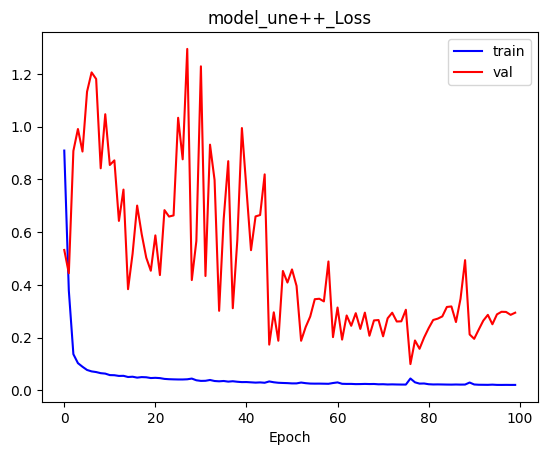

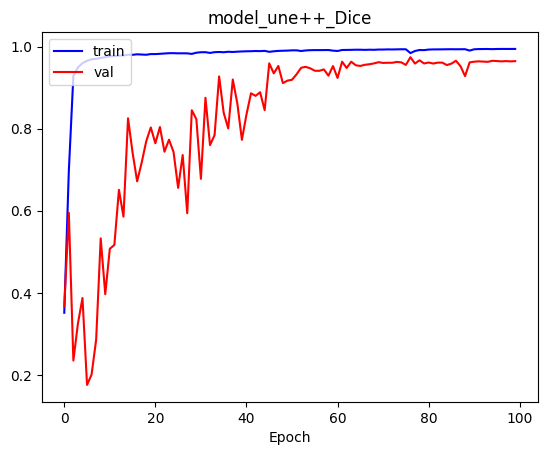

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('model_une++_Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.title('model_une++_Dice')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test dice', score[1])

2/2 [==============================] - 8s 7s/step - loss: 0.3482 - dice_coef: 0.9623
Test loss:  0.3482438027858734
Test dice 0.9623064994812012


In [ ]:
pred = model.predict(x_test)
pred[pred>=0.5]=1
pred[pred<=0.5]=0

2/2 [==============================] - 0s 423ms/step


Text(0.5, 1.0, 'image')

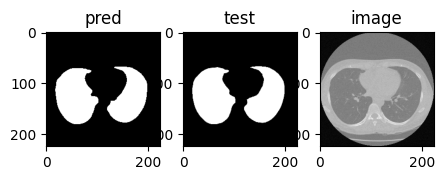

In [ ]:
plt.figure(figsize=(5, 8))
plt.subplot(1, 3, 1)
plt.imshow(pred[0], cmap='gray')
plt.title("pred")
plt.subplot(1, 3, 2)
plt.imshow(y_test[0], cmap='gray')
plt.title("test")
plt.subplot(1, 3, 3)
plt.imshow(x_test[0], cmap='gray')
plt.title("image")

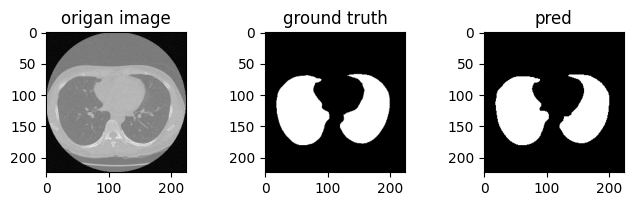

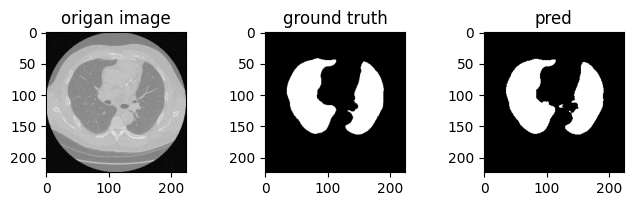

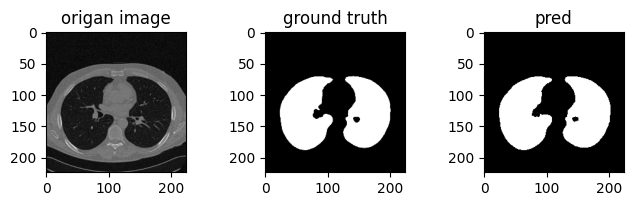

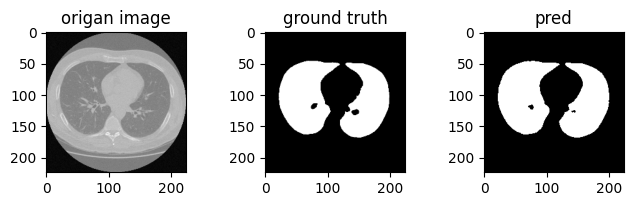

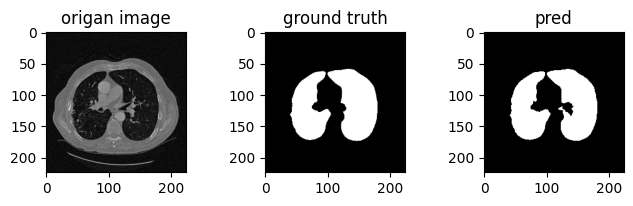

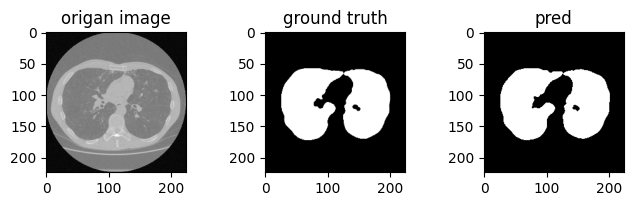

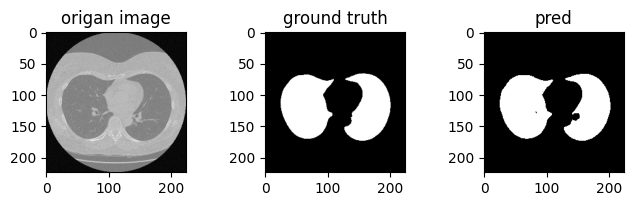

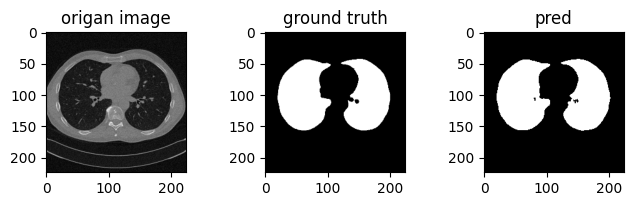

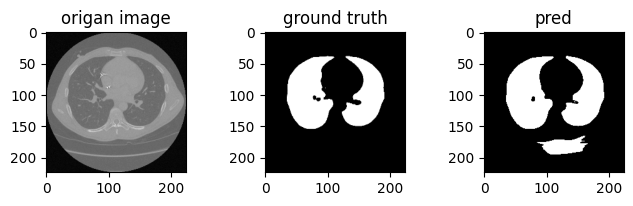

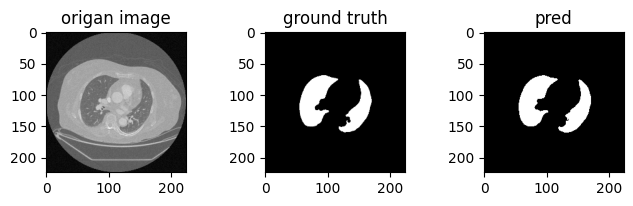

In [ ]:
for i in range(10):
  plt.figure(figsize=(8, 4))
  plt.subplot(2, 3, 1)
  plt.title("origan image")
  plt.imshow(x_test[i], cmap='gray')
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(y_test[i], cmap='gray')
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(pred[i], cmap='gray')
  plt.show()